## Load Modules

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import librosa
import scipy.io.wavfile
import os
import math
import matplotlib
import scipy.stats

from librosa.display import *
from librosa.effects import *
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib notebook

/Users/hyunwoogu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
os.chdir('./Samples')

In [3]:
lists = []
for wave in os.listdir(os.getcwd()):
    if "wav" in wave:
        lists.append(wave)
        
res = []

for wave in lists:
    data, fs = librosa.load(wave)
    data = data/np.ptp(data)
    res.append(data.shape[0])
    
res = np.array(res)
np.mean(res)

87169.0

In [4]:
def add_noise(wav):
    wn = np.random.normal(0, 1, len(wav))
    wav_noise = wav + 0.01*wn
    return (wav_noise)

def onset(data):
    cnt = 0  
    for i in data:
        cnt += 1
        if i > 1e-2:
            return(data[(cnt-1):])
            break
            
def termin(data):
    cnt = 0
    for i in reversed(data):
        cnt += 1
        if i > 1e-2:
            return(data[:(len(data)-cnt+1)])
            break

## Preprocessing

In [15]:
data, fs = librosa.load("CD_Happy.wav")

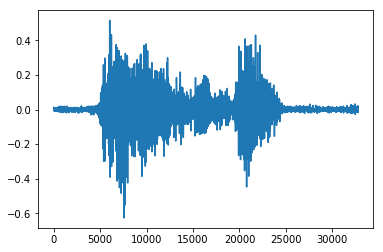

In [16]:
k = onset(data)
k = termin(k)

k = librosa.effects.time_stretch(k, len(k)/ fs / 1.5)
plt.plot(range(len(k)), k)

# librosa.output.write_wav('TEST5.wav', k, fs)

In [17]:
STFT_test = librosa.stft(k, n_fft=256, hop_length=int(0.01 * 8000), window='hann')
DATA_hat  = librosa.istft(STFT_test)

# librosa.output.write_wav('TEST6.wav', DATA_hat, fs)

(129, 410)

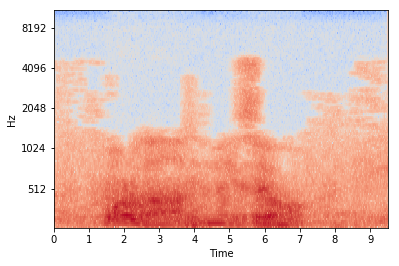

In [18]:
specshow(np.log(abs(STFT_test)), sr=fs, x_axis='time', y_axis='mel')
STFT_test.shape

## Data Augmentation

In [60]:
foo = 'Sad'
bar = 'Happy'

ListSad   = np.array(lists)[[i for i, v in enumerate(lists) if foo in v]]
ListHappy = np.array(lists)[[i for i, v in enumerate(lists) if bar in v]]

Happy_M = np.zeros([129, 410])
Happy_P = np.zeros([129, 410])
Sad_M   = np.zeros([129, 410])
Sad_P   = np.zeros([129, 410])

<IPython.core.display.Javascript object>


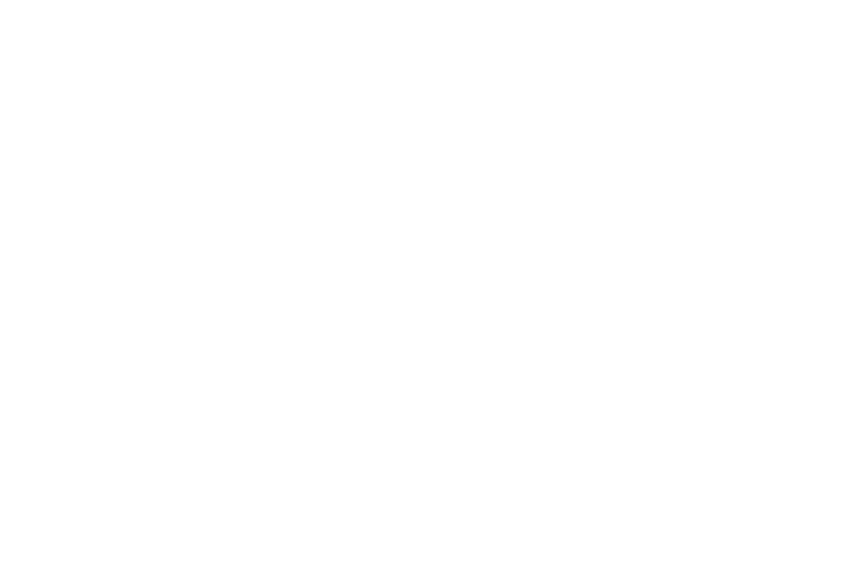

<IPython.core.display.Javascript object>


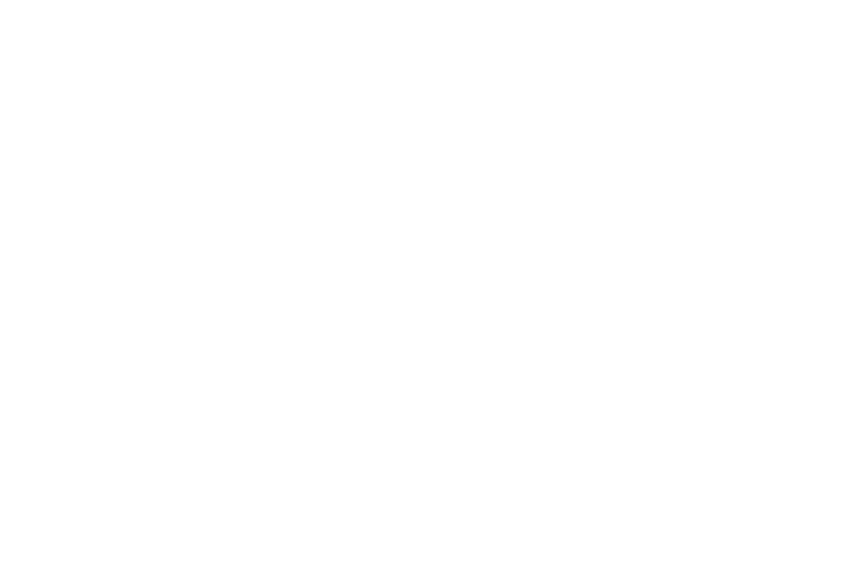

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

err = 0

for wave in ListSad:
    data, fs = librosa.load(wave)
    for i in range(100):
        data_no = add_noise(data)
        trimmed = onset(data_no)
        trimmed = termin(trimmed)

        trimmed = librosa.effects.time_stretch(trimmed, len(trimmed)/ fs / 1.5)

        STFT    = librosa.stft(trimmed, n_fft=256, hop_length=int(0.01 * 8000), window='hann')
        M, P    = librosa.magphase(STFT)
        logM    = np.log(M)
        if (logM.shape != (129, 410)):
            err += 1
            continue
        
        ax.clear()
        specshow(logM, sr=fs)
        fig.canvas.draw()
        plt.tight_layout()
    
        Sad_M = np.vstack((Sad_M, logM))
        Sad_P = np.vstack((Sad_P, P))    
        
SadX = np.reshape(Sad_M, [ListSad.shape[0]*100+1-err, 129, 410])
SadX = SadX[1:, :, :]
SadP = np.reshape(Sad_P, [ListSad.shape[0]*100+1-err, 129, 410])
SadP = SadP[1:, :, :]

In [112]:
dataX = np.vstack((HappyX, SadX))
dataX = np.reshape(dataX, [497+400, 129, 410])
dataY = np.repeat(np.array([1, 0]), [497, 400])

In [180]:
CheckX = np.vstack((HappyP, SadP))
CheckX = np.reshape(CheckX, [497+400, 129, 410])
CheckY = np.repeat(np.array([1, 0]), [497, 400])

CheckX = CheckX[inx, :, :]
CheckY = CheckY[inx]

In [113]:
inx = np.array(range(497+400))
np.random.shuffle(inx)

dataX = dataX[inx, :, :]
dataY = dataY[inx]

dataX = np.concatenate((dataX, dataX[1:4, :, :]), axis=0)
dataY = np.concatenate((dataY, dataY[1:4]), axis=0)
dataY = to_categorical(dataY, 2)

## Hyperparameters

In [161]:
total_epoch = 100
batch_size  = 100
n_hidden = 256
n_input  = 129 * 410
n_noise  = 128
n_class  = 2

## Model

In [167]:
tf.reset_default_graph()

In [168]:
X = tf.placeholder(tf.float32, [None, n_input])
Y = tf.placeholder(tf.float32, [None, n_class])
Z = tf.placeholder(tf.float32, [None, n_noise])

In [169]:
def generator(noise, labels):
    with tf.variable_scope('generator'):
        inputs = tf.concat([noise, labels], 1)
        hidden = tf.layers.dense(inputs, n_hidden,
                                 activation=tf.nn.relu)
        output = tf.layers.dense(hidden, n_input,
                                 activation=tf.nn.sigmoid)

    return output


def discriminator(inputs, labels, reuse=None):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()

        inputs = tf.concat([inputs, labels], 1)

        hidden = tf.layers.dense(inputs, n_hidden,
                                 activation=tf.nn.relu)
        output = tf.layers.dense(hidden, 1,
                                 activation=None)

    return output


def get_noise(batch_size, n_noise):
    return np.random.uniform(-1., 1., size=[batch_size, n_noise])

## Loss Function

In [170]:
G = generator(Z, Y)
D_real = discriminator(X, Y)
D_gene = discriminator(G, Y, True)

loss_D_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_real, labels=tf.ones_like(D_real)))
loss_D_gene = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_gene, labels=tf.zeros_like(D_gene)))

loss_D = loss_D_real + loss_D_gene
loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_gene, labels=tf.ones_like(D_gene)))


vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

train_D = tf.train.AdamOptimizer().minimize(loss_D, var_list=vars_D)
train_G = tf.train.AdamOptimizer().minimize(loss_G, var_list=vars_G)

## Train!

In [171]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(900/batch_size)
loss_val_D, loss_val_G = 0, 0

saver = tf.train.Saver()

for epoch in range(total_epoch):
    for i in range(total_batch):
        batch_xs = np.reshape(dataX[batch_size*i:batch_size*(i+1), :, :], [batch_size, n_input])
        batch_ys = np.reshape(dataY[batch_size*i:batch_size*(i+1), :], [batch_size, 2])
        noise = get_noise(batch_size, n_noise)

        _, loss_val_D = sess.run([train_D, loss_D],feed_dict={X: batch_xs, Y: batch_ys, Z: noise})
        _, loss_val_G = sess.run([train_G, loss_G],feed_dict={Y: batch_ys, Z: noise})

    print('Epoch:', '%04d' % epoch,
          'D loss: {:.4}'.format(loss_val_D),
          'G loss: {:.4}'.format(loss_val_G))

    if epoch == 0 or (epoch + 1) % 10 == 0:
        sample_size = 2
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G, feed_dict={Y: dataY[:2, :], Z: noise}) ## 0, 1


print('Optimization Completed!')

saver.save(sess, '180212_model',global_step=1000)

Epoch: 0000 D loss: 0.0 G loss: 769.6
Epoch: 0001 D loss: 0.0 G loss: 678.7
Epoch: 0002 D loss: 0.0 G loss: 420.4
Epoch: 0003 D loss: 0.0 G loss: 226.8
Epoch: 0004 D loss: 1.775e-28 G loss: 112.5
Epoch: 0005 D loss: 3.711e-14 G loss: 66.1
Epoch: 0006 D loss: 8.129e-11 G loss: 44.1
Epoch: 0007 D loss: 1.316e-08 G loss: 31.11
Epoch: 0008 D loss: 3.57e-07 G loss: 24.22
Epoch: 0009 D loss: 8.871e-06 G loss: 19.06
Epoch: 0010 D loss: 4.026e-05 G loss: 15.15
Epoch: 0011 D loss: 0.0001306 G loss: 12.38
Epoch: 0012 D loss: 0.0002087 G loss: 11.68
Epoch: 0013 D loss: 0.0001599 G loss: 11.26
Epoch: 0014 D loss: 0.0003102 G loss: 10.78
Epoch: 0015 D loss: 0.0002688 G loss: 10.25
Epoch: 0016 D loss: 0.0004671 G loss: 9.514
Epoch: 0017 D loss: 0.000813 G loss: 8.976
Epoch: 0018 D loss: 0.001972 G loss: 7.506
Epoch: 0019 D loss: 0.003498 G loss: 6.873
Epoch: 0020 D loss: 0.005916 G loss: 6.647
Epoch: 0021 D loss: 0.004561 G loss: 6.449
Epoch: 0022 D loss: 0.005805 G loss: 6.13
Epoch: 0023 D loss: 0.

KeyboardInterrupt: 

## Results

In [199]:
res = np.reshape(samples, [2, 129, 410])

In [229]:
res0 = librosa.decompose.nn_filter(np.exp(res[0, :, :]), aggregate=np.median, metric='cosine') * CheckX[0, :, :]
res1 = librosa.decompose.nn_filter(np.exp(res[1, :, :]), aggregate=np.median, metric='cosine') * CheckX[1, :, :]

res0 = librosa.istft(res0, hop_length=int(0.01 * 8000), window='hann')
res1 = librosa.istft(res1, hop_length=int(0.01 * 8000), window='hann')

res0 = librosa.effects.time_stretch(res0, len(res0)/ fs / 2)
res1 = librosa.effects.time_stretch(res1, len(res1)/ fs / 2)

librosa.output.write_wav('SAD.wav',   res0, fs)
librosa.output.write_wav('HAPPY.wav', res1, fs)

<IPython.core.display.Javascript object>


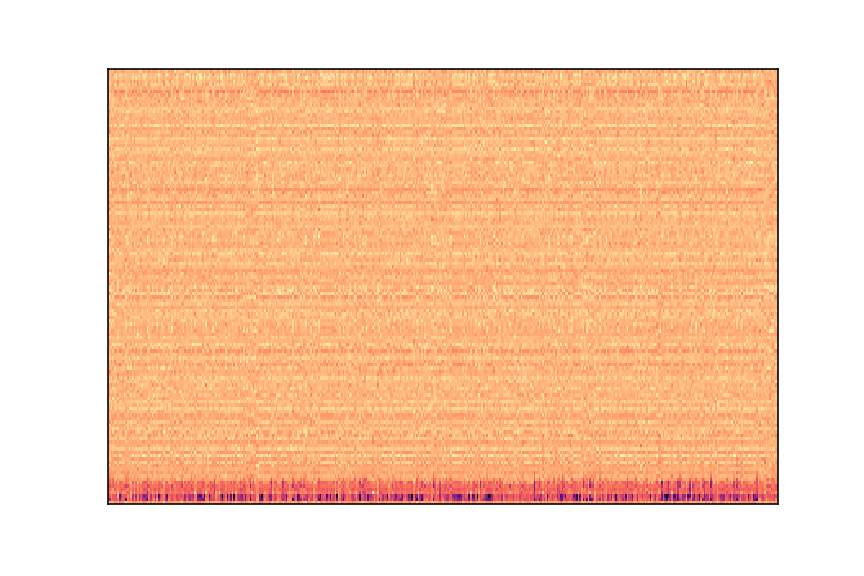

In [226]:
specshow(librosa.decompose.nn_filter(np.exp(res[0, :, :]), aggregate=np.median, metric='cosine'))